In [1]:
from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import torch
import lightning as pl
from ipsl_dcpp.model.pangu import PanguWeather
from hydra import compose, initialize
from omegaconf import OmegaConf

import hydra
import os
os.environ['SLURM_NTASKS_PER_NODE'] = '1'
torch.set_default_dtype(torch.float32)
# os.environ["CUDA_VISIBLE_DEVICES"]=""
#torch.set_default_tensor_type(torch.FloatTensor)

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
pl.seed_everything(cfg.experiment.seed)
train = hydra.utils.instantiate(
    cfg.experiment.train_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)

train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=2,
    shuffle=True,
    num_workers=1
)

val = hydra.utils.instantiate(
    cfg.experiment.val_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)

val_dataloader = torch.utils.data.DataLoader(
    val,
    batch_size=1,
    shuffle=False,
    num_workers=1
)

#batch = next(iter(train_dataloader))
model = hydra.utils.instantiate(
    cfg.experiment.module,
    backbone=hydra.utils.instantiate(
        cfg.experiment.backbone,
    ),
    dataset=train_dataloader.dataset

)
trainer = pl.Trainer(
    max_epochs=cfg.experiment.max_epochs,
    enable_checkpointing=True,
    log_every_n_steps=1,
   # max_steps=cfg.experiment.max_steps if not cfg.debug else 10,
    precision="16-mixed",
    #precision='32',
    profiler='simple' if cfg.debug else None,
   # devices=cfg.experiment.num_gpus,
   # strategy='ddp_find_unused_parameters_true',
    #limit_train_batches=0.01 if cfg.debug else 1
    #limit_val_batches=0.01 if cfg.debug else 1,
    num_sanity_val_steps=1,
  #  device='cpu',
  #accelerator='mps',
  #CONV3D not supported by mps, have to use cpu when local 
    accelerator= 'mps' if cfg.environment.name == 'local' else 'gpu',
    fast_dev_run=10
)


Seed set to 0
/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025535429/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Using 16bit Automatic Mixed Precision (AMP)
/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tens

In [2]:
# trainer.fit(
#     model=model,
#     train_dataloaders=train_dataloader)
# trainer.logged_metrics
checkpoint_path = torch.load(f'../epoch=00.ckpt',map_location=torch.device('cpu'))
model.load_state_dict(checkpoint_path['state_dict'])
#trainer.test(model, val_dataloader)
batch = next(iter(val_dataloader))
#history = model.sample_rollout(batch)

In [3]:
sample,batch,steps = model.sample(batch)


tensor(990)
tensor(980)
tensor(970)
tensor(960)
tensor(950)
tensor(940)
tensor(930)
tensor(920)
tensor(910)
tensor(900)
tensor(890)
tensor(880)
tensor(870)
tensor(860)
tensor(850)
tensor(840)
tensor(830)
tensor(820)
tensor(810)
tensor(800)
tensor(790)
tensor(780)
tensor(770)
tensor(760)
tensor(750)
tensor(740)
tensor(730)
tensor(720)
tensor(710)
tensor(700)
tensor(690)
tensor(680)
tensor(670)
tensor(660)
tensor(650)
tensor(640)
tensor(630)
tensor(620)
tensor(610)
tensor(600)
tensor(590)
tensor(580)
tensor(570)
tensor(560)
tensor(550)
tensor(540)
tensor(530)
tensor(520)
tensor(510)
tensor(500)
tensor(490)
tensor(480)
tensor(470)
tensor(460)
tensor(450)
tensor(440)
tensor(430)
tensor(420)
tensor(410)
tensor(400)
tensor(390)
tensor(380)
tensor(370)
tensor(360)
tensor(350)
tensor(340)
tensor(330)
tensor(320)
tensor(310)
tensor(300)
tensor(290)
tensor(280)
tensor(270)
tensor(260)
tensor(250)
tensor(240)
tensor(230)
tensor(220)
tensor(210)
tensor(200)
tensor(190)
tensor(180)
tensor(170)
tens

In [4]:
batch['next_time']

['2002-02']

In [5]:
sample.keys()

dict_keys(['next_state_surface'])

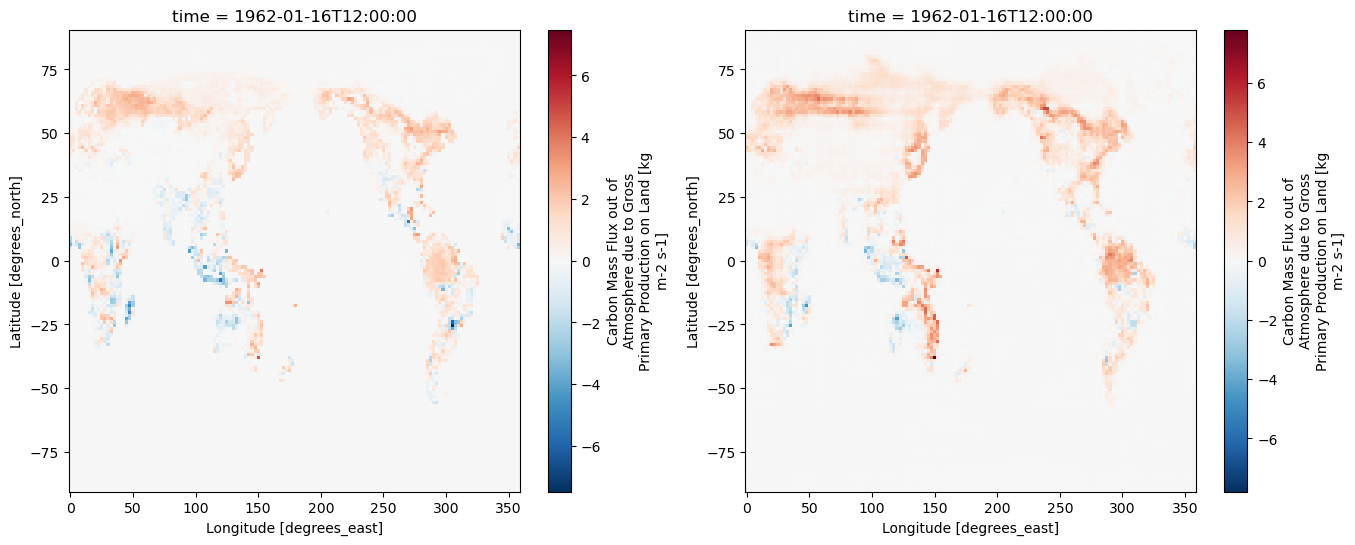

In [13]:
import xarray as xr
import matplotlib.pyplot as plt
#get shell
ds = xr.open_dataset(train.files[0])
shell = ds.isel(time=0)
var_name = 'gpp'
var_index = cfg.experiment.surface_variables.index(var_name)

#plot lat lon map of first rollout
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))
#shell[var_name].data = steps[49][0,0,0]
shell[var_name].data = batch['next_state_surface'][0][4]
shell[var_name].plot.pcolormesh(ax=ax1)
shell[var_name].data = sample['next_state_surface'][0][4]
shell[var_name].plot.pcolormesh(ax=ax2)

MovieWriter ffmpeg unavailable; using Pillow instead.


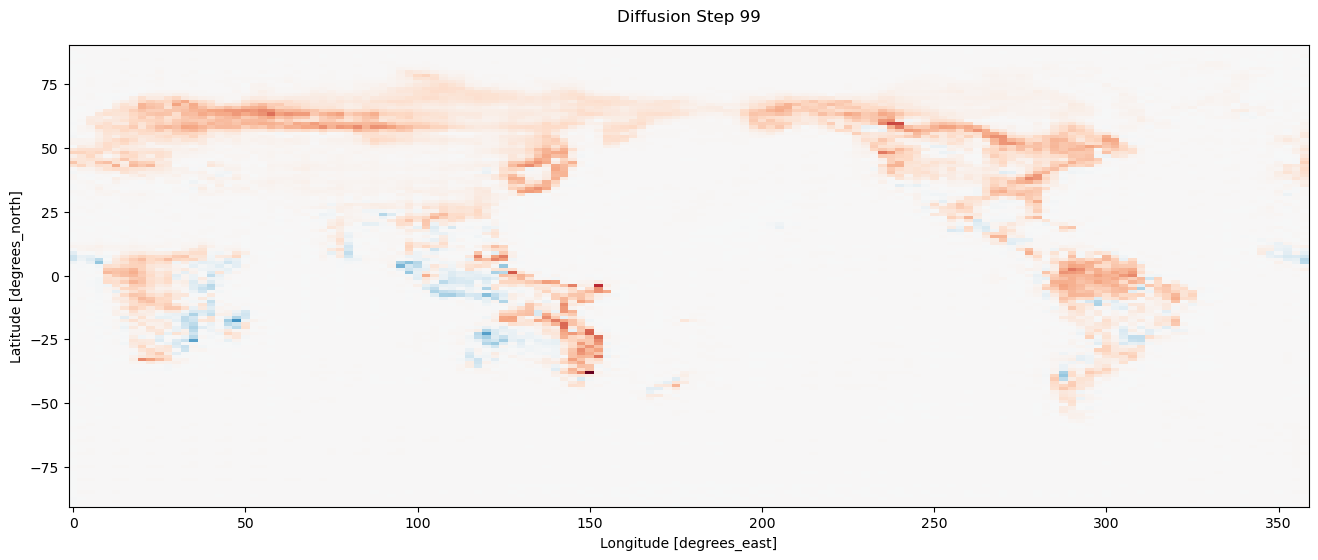

In [14]:
# from celluloid import Camera
# fig, ax1 = plt.subplots(1, figsize=(16, 6))
# camera = Camera(fig)
# ax1.set_title("diffusion steps")
# ds = xr.open_dataset(val.files[0])
# shell = ds.isel(time=0)

# # Animate plot over time
# for time_step in range(len(steps)):
#     shell['tas'].data = steps[time_step][0,0,0]
#     shell['tas'].plot.pcolormesh(ax=ax1,add_colorbar=False)
#     ax1.set_title(f"diffusion step {time_step}")    
#     camera.snap()
# anim = camera.animate()
# anim.save(f"diffusion.gif")

from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np


fig, ax1 = plt.subplots(1, figsize=(16, 6))
container = []
for time_step in range(len(steps)):
    shell['tas'].data = steps[time_step][0,4]
   # line = ax1.pcolormesh(steps[time_step][0,0,0])
    line = shell['tas'].plot.pcolormesh(ax=ax1,add_colorbar=False)
    title = ax1.text(0.5,1.05,"Diffusion Step {}".format(time_step), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax1.transAxes, )
    container.append([line, title])
plt.title('')

ani = animation.ArtistAnimation(fig, container, interval=100, blit=True)
ani.save("diffusion.gif")

In [3]:
trainer.lightning_module.metrics.compute()

{'T2m_err': tensor(0.0004),
 'T2m_var': tensor(0.0009),
 'T2m_norm': tensor(0.0009),
 'T2m_spskr': tensor(1.7320),
 'T2m_unbiased_spskr': tensor(inf),
 'T2m_crps': tensor(0.0090),
 'U10_err': tensor(0.0004),
 'U10_var': tensor(0.0009),
 'U10_norm': tensor(0.0009),
 'U10_spskr': tensor(1.7320),
 'U10_unbiased_spskr': tensor(inf),
 'U10_crps': tensor(0.0090),
 'SP_err': tensor(0.0004),
 'SP_var': tensor(0.0009),
 'SP_norm': tensor(0.0009),
 'SP_spskr': tensor(1.7320),
 'SP_unbiased_spskr': tensor(inf),
 'SP_crps': tensor(0.0090),
 'headline_unbiased_spskr': tensor(inf),
 'headline_spskr': tensor(1.7320)}